## Title

# Table of Contents
*[Data Import](#dataimport)<br>
*[Data Cleaning](#datacleaning)<br>
    *[IMDB Cleaning](#imdbclean)<br>
*[Exploratory Analysis](#explore)<br>
    *[IMDB Rating, Genres, and Directors](#imdbrat)<br>


# Data Import <a class="anchor" id="dataimport"></a>

In [1]:
# Import linraries and modules

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 

In [2]:
#Access IMDB data through sqlite3

# Connect to sqlite3
conn = sqlite3.connect('../data/im.db')

# Query and join IMDB tables movie_basics, movie_ratings and direcotr information (tables directors and perons)

df_imdb = pd.read_sql("""
    SELECT *
    FROM 
    movie_basics AS mb
        LEFT JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
        LEFT JOIN
            (SELECT *
            FROM directors GROUP BY movie_id) AS dr
            ON mb.movie_id = dr.movie_id
        LEFT JOIN persons AS ps
            ON dr.person_id = ps.person_id
""", conn)

# Data Cleaning <a class="anchor" id="datacleaning"></a>

### IMDB Cleaning <a class="anchor" id="imdbclean"></a>

In [4]:
# Split genres from IMDB data into spereate columns
df_imdb[['Genre_1','Genre_2', 'Genre_3']] = df_imdb["genres"].str.split(",",expand=True)

# Add colum of avrage rating relative to mean of overall average rating
df_imdb['rating_relative_to_avg'] = df_imdb['averagerating'] - df_imdb['averagerating'].mean()


# Create dataframe of counts of genres
# Count genres by column
df_gen_cnt = df_imdb[['Genre_1', 'Genre_2', 'Genre_3']].apply(pd.Series.value_counts)

# Make NaNs 0
df_gen_cnt = df_gen_cnt.fillna(0)

# Get total count per genre and add to total counts column
df_gen_cnt['total_gen_cnt'] = df_gen_cnt['Genre_1'] + df_gen_cnt['Genre_2'] + df_gen_cnt['Genre_3']

# Create a datafram of genre combinations and their averagerating
df_genres = df_imdb.loc[:, ["Genre_1","Genre_2","Genre_3", "averagerating", "numvotes", 'start_year']]

# A dataframe of genre value counts
df_gen_cnt = df_imdb[['Genre_1', 'Genre_2', 'Genre_3']].apply(pd.Series.value_counts)
df_gen_cnt = df_gen_cnt.fillna(0)
df_gen_cnt['total_gen_cnt'] = df_gen_cnt['Genre_1'] + df_gen_cnt['Genre_2'] + df_gen_cnt['Genre_3']
df_genres = df_genres.dropna(subset=['averagerating'])


# Exploratory Data Analysis <a class="anchor" id="explore"></a>

### IMBD Rating, Genres and Directors <a class="anchor" id="imdbrat"></a>

In [5]:
# Looking at the top 10 rated genre combinations with > 100000 votes since 2012
df_top10_gen_comb_rat = df_genres[(df_genres['numvotes'] >= 100000) & (df_genres['start_year'] >= 2012)].groupby(['Genre_1', 'Genre_2', 'Genre_3']).mean().sort_values('averagerating', ascending=False)[:10]
df_top10_gen_comb_rat

averagerating   numvotes  start_year
Genre_1   Genre_2   Genre_3                                       
Action    Drama     War               8.450  241280.50     2015.00
Animation Drama     Fantasy           8.400  134084.00     2016.00
Adventure Drama     Sci-Fi            8.300  989725.00     2014.50
Comedy    Drama     Thriller          8.100  151123.00     2014.00
                    Fantasy           8.000  200574.00     2013.50
Biography Drama     Music             8.000  345466.00     2018.00
Action    Biography Drama             7.850  291407.75     2014.00
Drama     Music     Romance           7.800  249245.00     2018.00
          Mystery   Sci-Fi            7.775  385403.75     2015.25
Biography Drama     Thriller          7.700  415517.00     2013.75

In [6]:
#Top 50 movies by rating with at least 100,000 votes and released no later than 2012
df_top50_rat = df_imdb[(df_imdb['numvotes'] >= 100000) & (df_imdb['start_year'] >= 2012)] .sort_values('averagerating', ascending=False)[0:50]

<BarContainer object of 10 artists>

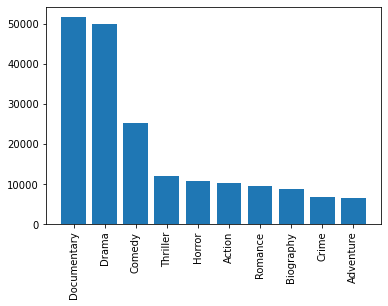

In [7]:
# Viz of genre counts
top10_gen_cnt = df_gen_cnt.sort_values('total_gen_cnt', ascending=False)[0:10]

fig, ax = plt.subplots()

x = top10_gen_cnt.index
y = top10_gen_cnt['total_gen_cnt']

plt.xticks(rotation=90)

ax.bar(x,y)

<ipython-input-8-acc1ed2c1e51>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x1, rotation=80)
<ipython-input-8-acc1ed2c1e51>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x2, rotation=80)


<BarContainer object of 10 artists>

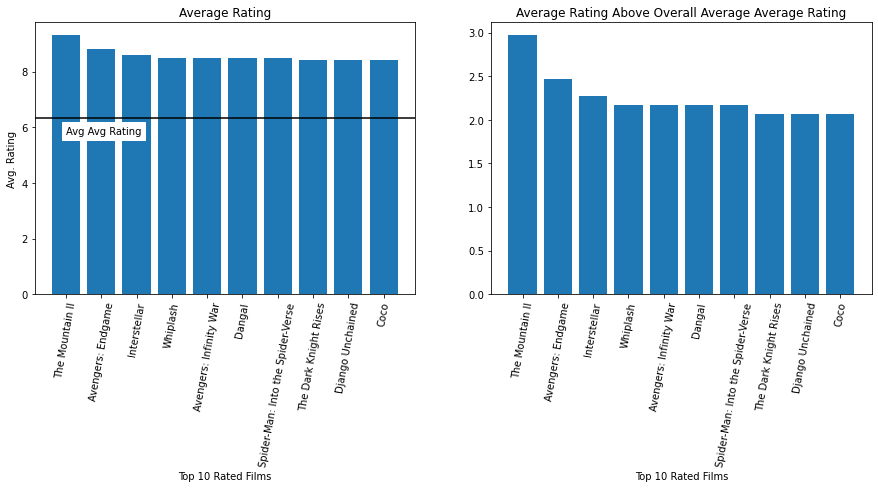

In [8]:
# Viz of Top 10 movies by rating with at least 100,000 votes and released no later than 2012
df_top10_rat = df_top50_rat[0:10]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

x1 = df_top10_rat['primary_title']
y1 = df_top10_rat['averagerating']

x2 = df_top10_rat['primary_title']
y2 = df_top10_rat['rating_relative_to_avg']

ax1.axhline(6.332729, c="black")
ax1.text(0,5.75,"Avg Avg Rating", backgroundcolor="White")

ax1.set_xticklabels(x1, rotation=80)
ax2.set_xticklabels(x2, rotation=80)

ax1.set_xlabel("Top 10 Rated Films")
ax1.set_ylabel("Avg. Rating")

ax2.set_xlabel("Top 10 Rated Films")
ax.set_ylabel("Avg. Rating Above Avg. Avg. Rating")

ax1.set_title("Average Rating")
ax2.set_title("Average Rating Above Overall Average Average Rating")

ax1.bar(x1,y1)
ax2.bar(x2,y2)

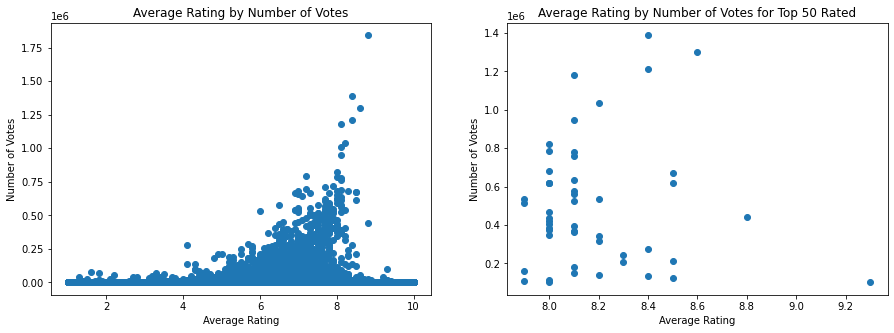

In [9]:
# Viz of comparison of number of votes and average rating

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

x1 = df_imdb['averagerating']
y1 = df_imdb['numvotes']

x2 = df_top50_rat['averagerating']
y2 = df_top50_rat['numvotes']


ax1.set_xlabel("Average Rating")
ax1.set_ylabel("Number of Votes")
ax1.set_title("Average Rating by Number of Votes")

ax2.set_xlabel("Average Rating")
ax2.set_ylabel("Number of Votes")
ax2.set_title("Average Rating by Number of Votes for Top 50 Rated")

ax1.scatter(x1,y1)
ax2.scatter(x2,y2)

In [1]:
# Viz of the directors who have more than one film in the top 50 rated movies since 2012 with more than 100000 votes

# Create a series of directors who have more than one film in the top 50 rated movies since 2012 with more than 100000 votes
dir_mul_top50 = df_top50_rat.value_counts('primary_name')[0:7]

fig, ax = plt.subplots()

x = dir_mul_top50.index
y = dir_mul_top50.values

ax.set_xlabel('Movies in Top 50')
ax.set_ylabel('Director')
ax.set_title('Directors with More Than One Movie in Top 50\n with at Least 100000 votes Since 2012')

ax.barh(x,y)
plt.gca().invert_yaxis()

NameError: name 'df_top50_rat' is not defined